In [30]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import datetime
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

In [31]:
# ========================================================
# = Parameters for plotting
# ========================================================
FONT_SIZE = 14
rc={'font.size': FONT_SIZE, 'axes.labelsize': FONT_SIZE, 'legend.fontsize': FONT_SIZE,
    'axes.titlesize': FONT_SIZE, 'xtick.labelsize': FONT_SIZE, 'ytick.labelsize': FONT_SIZE}
plt.rcParams.update(**rc)
plt.rc('font', weight='bold')

# 1 Functions

In [32]:
##==============================================================================
## cleaning data: outlier, missing data at midnight, and consective missing data
##==============================================================================
def preprocess_missingdata(df, MIDP, pvsize):
    # Step 1. replace the negative values with zero
    df.loc[df[MIDP]<0, MIDP] = 0
    # Step 2. replace outlier (larger than pvsize) with nan
    df_outlier_idx = df[df[MIDP].astype(float) > 1.2*pvsize]
    df.iloc[df_outlier_idx.index.to_list(), 1] = np.nan
    
    # Step 3. fill the nan
    df.fillna(method='ffill', inplace=True)
    df.fillna(method='bfill', inplace=True)
    return df

# 2 Read Data

## 2.1. Raw Data

In [ ]:
# read meta table
df_monitors = pd.read_csv('../input_data/MNTR_ddb_20230630.csv', header=0)
df_sites = pd.read_csv('../input_data/SITE_nodeType_20230630.csv')
att_list = ['latitude', 'longitude', 'tilt', 'azimuth', 'loss', 'pvSizeWatt']
df_monitors['latitude'] = [x[1:] for x in df_monitors['latitude']]
# df_monitors.head()

## 2.2 Read Labelled Table

In [ ]:
# read labelled table to find target monitors with fault and the time period
# you can also set the time period mannually
df_label_raw = pd.read_excel('../machine_learning/dataset/Diagno Labelling.xlsx')
df_label_raw['diagnoId'] = df_label_raw['diagnoId'].astype(str)
# df_label_raw.head()

## 2.3 Read Raw Data of the AC Generation

In [ ]:
# read raw data with 5-min time resolution
file_path = '../preprocessed_data/5min_rawdata_20230630.csv'
df_raw = pd.read_csv(file_path, header=0, index_col=0)
# df_raw.head()

## 2.4 Check One Monitor

In [36]:
# MID = '5708442'
# MID = '6039648' # normal, theoretical < actual
# MID = '4209848' # Normal
# MID =  'EY23-83LN-QK8Y-G8AE' # possible recurring
# MID = '987654359'
MID = 'BOPQ-75B2-AIOH-HTPZ'
# MID = '28594989'
MIDname = 'MNTR|'+MID
df_rawMID = df_raw[['time', MIDname]].copy()
df_rawMID['time'] = df_rawMID['time'].astype(str)
df_rawMID.index = range(len(df_rawMID.index))
df_rawMID['time'] = pd.to_datetime(df_rawMID['time']).dt.tz_localize(None)
df_rawMID.head()

,time,MNTR|BOPQ-75B2-AIOH-HTPZ
0,2021-01-01 00:00:00,NaN
1,2021-01-01 00:05:00,NaN
2,2021-01-01 00:10:00,NaN
3,2021-01-01 00:15:00,NaN
4,2021-01-01 00:20:00,NaN


In [ ]:
site_id = str(df_monitors.loc[df_monitors['source']==MIDname, 'siteId'].values[0])
print(site_id)
time_zone = df_sites.loc[df_sites['source']==site_id, 'timezone'].values[0]
print(time_zone)
latitude = df_monitors.loc[df_monitors['source']==str('MNTR|' + MID), 'latitude'].values[0][1:]
latitude = float(latitude)
print(latitude)
longitude = df_monitors.loc[df_monitors['source']==str('MNTR|' + MID), 'longitude'].values[0]
longitude = float(longitude)
pv_size = df_monitors.loc[df_monitors['source']== str('MNTR|' + MID), 'pvSizeWatt'].values[0]
print('PV size:', pv_size)

## 2.5 Data Preprocessing

In [38]:
df_rawMID = preprocess_missingdata(df=df_rawMID, MIDP=MIDname, pvsize=pv_size)
df_rawMID

,time,MNTR|BOPQ-75B2-AIOH-HTPZ
0,2021-01-01 00:00:00,3577.0
1,2021-01-01 00:05:00,3577.0
2,2021-01-01 00:10:00,3577.0
3,2021-01-01 00:15:00,3577.0
4,2021-01-01 00:20:00,3577.0
...,...,...
262364,2023-06-30 23:40:00,0.0
262365,2023-06-30 23:45:00,0.0
262366,2023-06-30 23:50:00,0.0
262367,2023-06-30 23:55:00,0.0


In [39]:
# find the labelled time period for a specific fault
df_label_mid = df_label_raw[df_label_raw['diagnoId']==MID]
df_label_mid.index = np.arange(len(df_label_mid))
mid_date_start, mid_date_end = df_label_mid.iloc[0, :][['faultStartdate', 'faultEnddate']].values
mid_date_start = mid_date_start - datetime.timedelta(days=3)
mid_date_start = mid_date_start.strftime('%Y-%m-%d')

mid_date_end = mid_date_end + datetime.timedelta(days=3)
mid_date_end = mid_date_end.strftime('%Y-%m-%d')

<Axes: xlabel='time'>

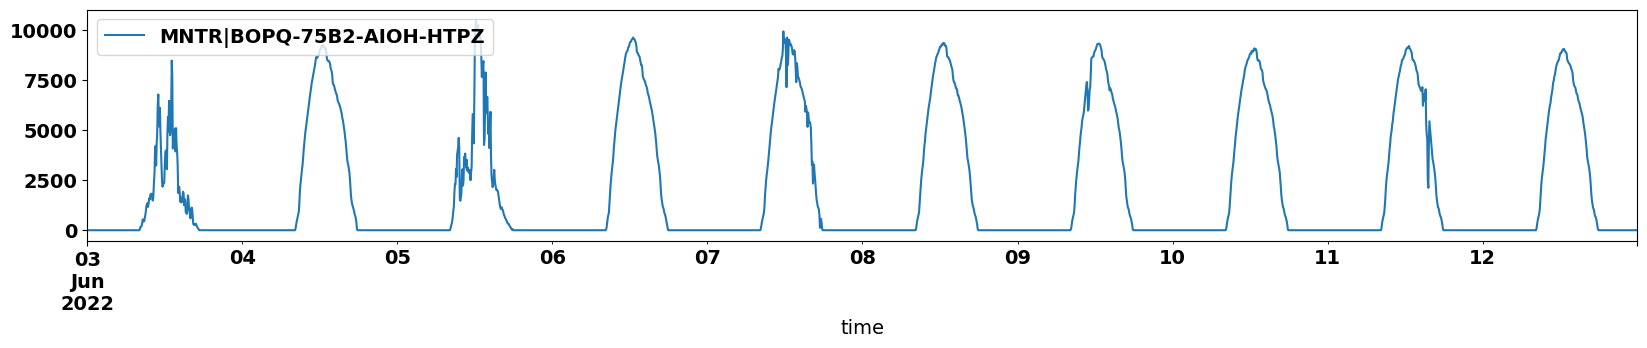

In [59]:
# slice window
df_MID = df_rawMID[(df_rawMID['time']>=mid_date_start)&(df_rawMID['time']<=mid_date_end)]
df_MID = df_MID.groupby(df_MID['time'].dt.date).filter(lambda group: len(group) >= 100)
df_MID.index = np.arange(len(df_MID))
df_MID.set_index('time').plot(figsize=(20, 3))

# 3 Calculate the theoretical generation of a cleark-sky day

In [41]:
from pvlib import irradiance
from pvlib import location
import pvlib

# default parameters
tilt = 10
azimuth=10
loss_factor = 0.85

In [42]:
##==============================================================================
## Calculate the thoretical power generation of PV systems with pvlib
##==============================================================================
def get_irradiance(loc, times, tilt, surface_azimuth):
    # Generate clearsky data using the Ineichen model, which is the default
    # The get_clearsky method returns a dataframe with values for GHI, DNI,and DHI
    clearsky = loc.get_clearsky(times)
    # Get solar azimuth and zenith to pass to the transposition function
    solar_position = loc.get_solarposition(times=times)
    # Use the get_total_irradiance function to transpose the GHI to POA
    POA_irradiance = irradiance.get_total_irradiance(
        surface_tilt=tilt,
        surface_azimuth=surface_azimuth,
        dni=clearsky['dni'],
        ghi=clearsky['ghi'],
        dhi=clearsky['dhi'],
        solar_zenith=solar_position['apparent_zenith'],
        solar_azimuth=solar_position['azimuth'])
    # Return DataFrame with only GHI and POA
    return pd.DataFrame({'GHI': clearsky['ghi'],
                         'POA': POA_irradiance['poa_global']})

In [43]:
##==============================================================================
## calculate the mean value of data larger than 99% percentile
##==============================================================================
def calculate_99perentile(time_series):
    filtered_arr = time_series[time_series != 0]
    ninetyeight_percent_max = np.percentile(filtered_arr, 99)
    filtered_data = [x for x in filtered_arr if x >= ninetyeight_percent_max]
    # Calculate the mean value of the filtered data
    mean_99th_percentile = np.mean(filtered_data)
    return mean_99th_percentile

In [44]:
time_index5min_local = pd.date_range(start=pd.to_datetime(mid_date_start).tz_localize(time_zone), end=pd.to_datetime(mid_date_end).tz_localize(time_zone), freq='5min')
loc = location.Location(latitude, longitude, tz=time_zone)

# calculate thoretical generation based PVlib
pvlib_irr = get_irradiance(loc, time_index5min_local, tilt, azimuth)
pvlib_irr['time']= time_index5min_local
pvlib_irr[['GHI', 'POA']] = pvlib_irr[['GHI', 'POA']]*pv_size*loss_factor/1000
# remove the day has only very limited time period
pvlib_irr = pvlib_irr.groupby(pvlib_irr['time'].dt.date).filter(lambda group: len(group) >= 100) 
df_MID['theor_gen.W'] = pvlib_irr['POA'].values

<Axes: xlabel='time'>

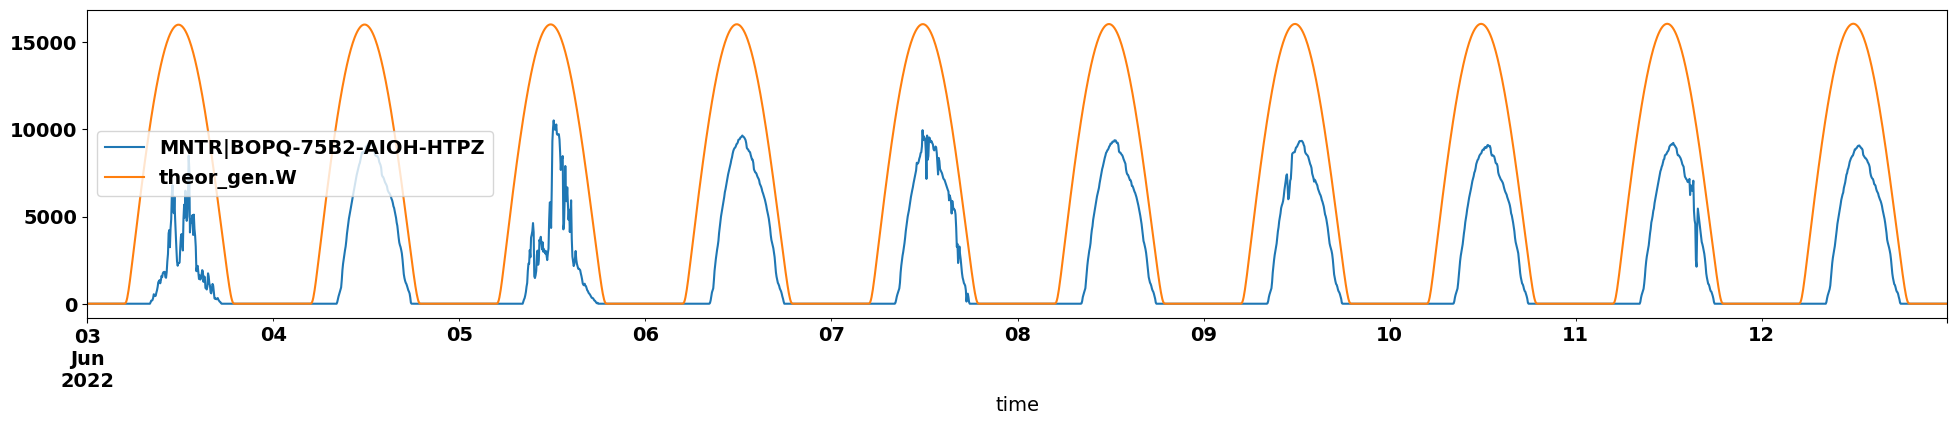

In [45]:
df_MID[['time', MIDname, 'theor_gen.W']].set_index('time').plot(figsize=(24, 4))

# 4 Rescale the Maximum Value

16049.189494276294 9954.333333333334


<Axes: xlabel='time'>

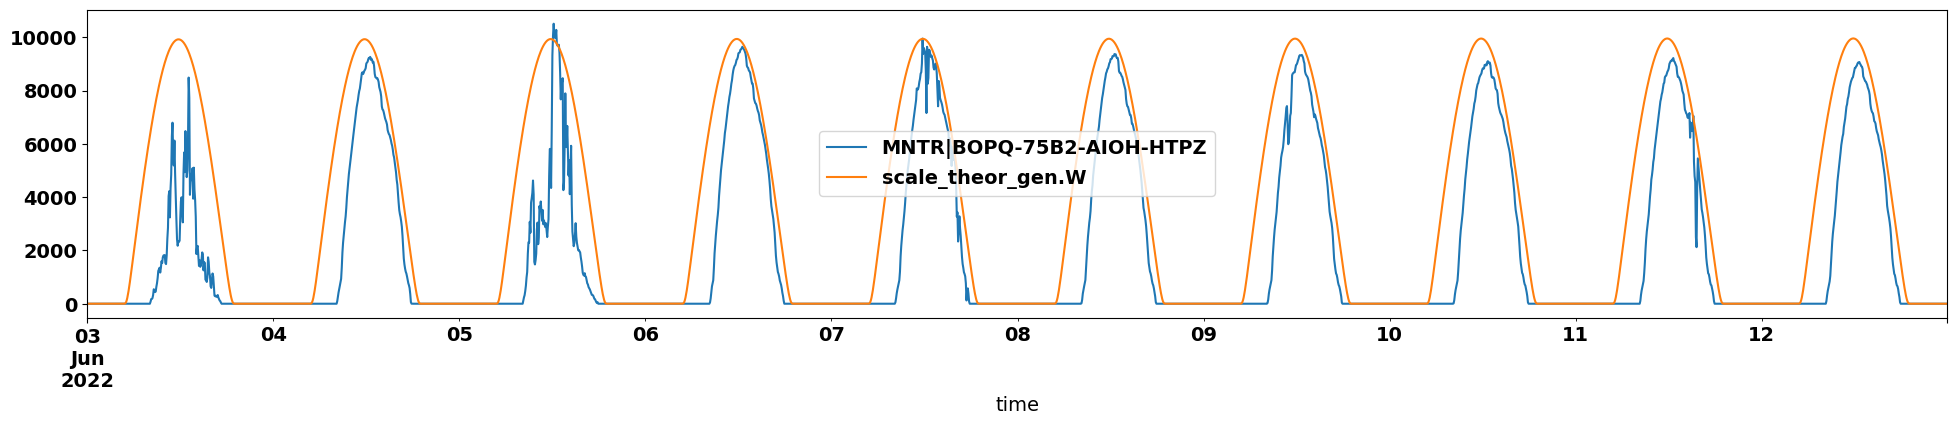

In [62]:
## ==== Find maximum values and rescale the theoretical generation ======================  
max_value1 = calculate_99perentile(time_series=pvlib_irr['POA'].values)
max_value2 = calculate_99perentile(time_series=df_MID[MIDname].values)
print(max_value1, max_value2)

# Normalize the first time series to have the same maximum value as the second time series

df_MID['scale_theor_gen.W'] = pvlib_irr['POA'].values*(max_value2 / max_value1)

df_MID[['time', MIDname, 'scale_theor_gen.W']].set_index('time').plot(figsize=(24, 4))

# 5 Shift Profile on Timeline (Align the Maximum Values)

In [47]:
# Find the index of the maximum value for each day
df_MID['date'] = df_MID['time'].dt.date
df_MID['shift_theor.W'] = np.nan
# df_MID['date'] = df_MID['date'].astype(str)
result = df_MID.groupby('date').apply(lambda x: x[[MIDname, 'scale_theor_gen.W']].idxmax()).reset_index(drop=True)
date_list = df_MID['date'].unique()
for i in range(len(result)):
    date_id = date_list[i]
    # Calculate time shift for alignment
    max_index1 = result['scale_theor_gen.W'].values[i]
    max_index2 = result[MIDname].values[i]
    index_shift = max_index2 - max_index1
    df_MID.loc[df_MID['date']==date_id, 'shift_theor.W'] = df_MID['scale_theor_gen.W'].shift(periods=index_shift)
df_MID

,time,MNTR|BOPQ-75B2-AIOH-HTPZ,theor_gen.W,scale_theor_gen.W,date,shift_theor.W
0,2022-06-03 00:00:00,0.0,0.0,0.0,2022-06-03,NaN
1,2022-06-03 00:05:00,0.0,0.0,0.0,2022-06-03,NaN
2,2022-06-03 00:10:00,0.0,0.0,0.0,2022-06-03,NaN
3,2022-06-03 00:15:00,0.0,0.0,0.0,2022-06-03,NaN
4,2022-06-03 00:20:00,0.0,0.0,0.0,2022-06-03,NaN
...,...,...,...,...,...,...
2875,2022-06-12 23:35:00,0.0,0.0,0.0,2022-06-12,0.0
2876,2022-06-12 23:40:00,0.0,0.0,0.0,2022-06-12,0.0
2877,2022-06-12 23:45:00,0.0,0.0,0.0,2022-06-12,0.0
2878,2022-06-12 23:50:00,0.0,0.0,0.0,2022-06-12,0.0


<Axes: xlabel='time', ylabel='MNTR|BOPQ-75B2-AIOH-HTPZ'>

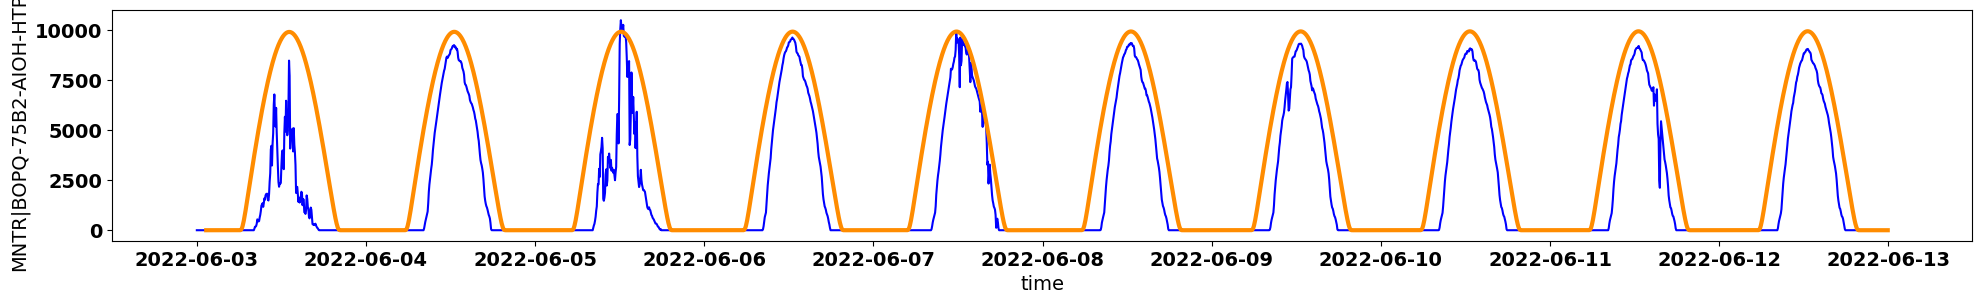

In [48]:
fig, axe = plt.subplots(nrows=1, figsize=(24, 3))
sns.lineplot(data=df_MID, x='time', y=MIDname, color='blue', ax=axe)
sns.lineplot(data=df_MID, x='time', y='shift_theor.W', color='darkorange', ax=axe, linewidth=3)

## 4.3 Calculate Difference

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


<Axes: xlabel='time', ylabel='Delta'>

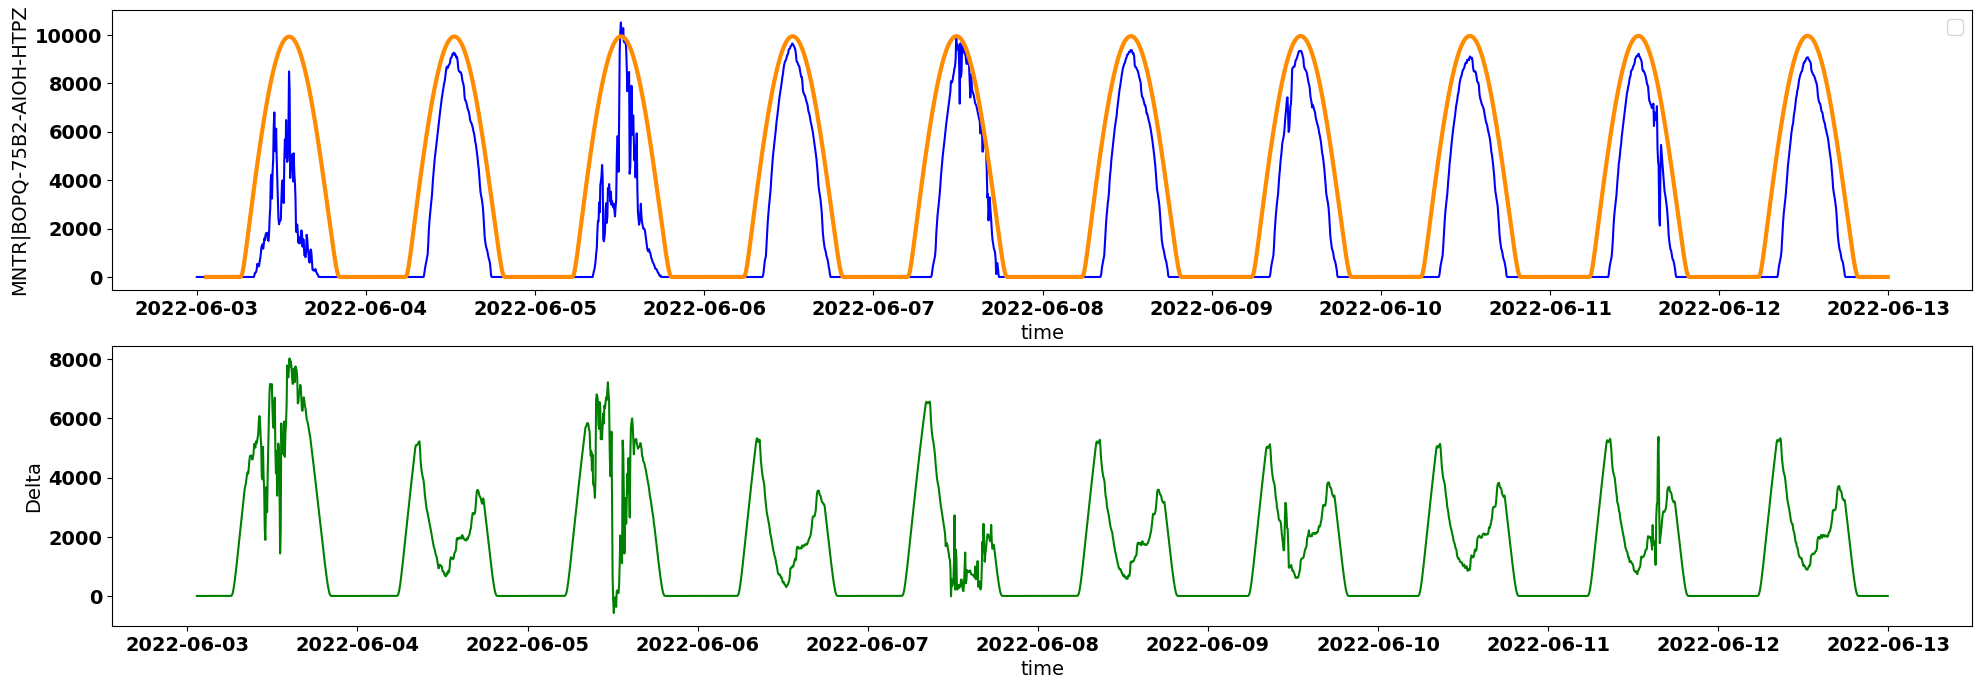

In [49]:
df_MID['Delta'] = df_MID['shift_theor.W'] - df_MID[MIDname]
fig, axe = plt.subplots(nrows=2, figsize=(24, 8))
sns.lineplot(data=df_MID, x='time', y=MIDname, color='blue', ax=axe[0])
sns.lineplot(data=df_MID, x='time', y='shift_theor.W', color='darkorange', linewidth=3, ax=axe[0])
axe[0].legend()
sns.lineplot(data=df_MID, x='time', y='Delta', color='green', ax=axe[1])

## 4.4 Find Consecutive Significant Reduction Compared with the Theoretical Generation

In [50]:
threshold_W = 0.15*pv_size
print(threshold_W)
threshold_T = 6
threshold_D = 3

3013.5


In [51]:
## ==========================================================##
## == find consecutive fault
## ==========================================================##
def consecutive_compare(df, threshold_time_period, measure_name, save_name):
    df['period'] = df[measure_name].diff().ne(0).cumsum()
    df['duration'] = df.groupby('period')[measure_name].transform('sum')
    df[save_name] = (df[measure_name]==True) & (df['duration']>=threshold_time_period)
    df.drop(['period', 'duration'], axis=1, inplace=True)
    return df

In [52]:
df_MID['Sig_Delta'] = df_MID['Delta']>threshold_W
df_MID = consecutive_compare(df=df_MID,  threshold_time_period=threshold_T, measure_name='Sig_Delta', save_name='consecutive_decrease')
df_MID[df_MID['consecutive_decrease']==True]


,time,MNTR|BOPQ-75B2-AIOH-HTPZ,theor_gen.W,scale_theor_gen.W,date,shift_theor.W,Delta,Sig_Delta,consecutive_decrease
94,2022-06-03 07:50:00,0.0,9417.132317,5840.872784,2022-06-03,3052.441086,3052.441086,True,True
95,2022-06-03 07:55:00,0.0,9671.688128,5998.758227,2022-06-03,3238.401644,3238.401644,True,True
96,2022-06-03 08:00:00,0.0,9922.510748,6154.328200,2022-06-03,3423.173308,3423.173308,True,True
97,2022-06-03 08:05:00,0.0,10169.500886,6307.521118,2022-06-03,3606.660751,3606.660751,True,True
98,2022-06-03 08:10:00,73.0,10412.559996,6458.275858,2022-06-03,3788.777259,3715.777259,True,True
...,...,...,...,...,...,...,...,...,...
2803,2022-06-12 17:35:00,554.0,3622.767592,2246.981769,2022-06-12,3823.276206,3269.276206,True,True
2804,2022-06-12 17:40:00,387.0,3339.748214,2071.442112,2022-06-12,3650.208634,3263.208634,True,True
2805,2022-06-12 17:45:00,252.0,3057.778757,1896.553656,2022-06-12,3476.340644,3224.340644,True,True
2806,2022-06-12 17:50:00,55.0,2777.359743,1722.626845,2022-06-12,3301.779426,3246.779426,True,True


## 4.5 Check the Time Location of the Significant Reduction

In [53]:
begining_day = [4, 11] # 
middle_day = [11, 14]
ending_day = [14, 21]

In [54]:
# check it is reduction happens at the begining/middle/ending of a day
df_MID['hour'] = df_MID['time'].dt.hour
df_MID_daily = pd.DataFrame(index=np.arange(len(date_list)), columns=['date', 'Dbegin', 'Dmiddle', 'Dend'])
df_MID_daily['date'] = date_list

# Check for reduction events based on time period boundaries
df_MID['Dbegin'] = (df_MID['hour'] < begining_day[-1]) & df_MID['consecutive_decrease']
df_MID['Dmiddle'] = (df_MID['hour'] >= middle_day[0]) & (df_MID['hour'] < middle_day[-1]) & df_MID['consecutive_decrease']
df_MID['Dend'] = (df_MID['hour'] > ending_day[0]) & df_MID['consecutive_decrease']

# # Group by date and aggregate using max to check if any True value exists for each day
df_MID_daily = df_MID.groupby('date')[['Dbegin', 'Dmiddle', 'Dend']].max()

df_MID_daily[['Dbegin', 'Dmiddle', 'Dend']] = df_MID_daily[['Dbegin', 'Dmiddle', 'Dend']].astype(bool)
df_MID_daily.reset_index(inplace=True)
df_MID_daily



,date,Dbegin,Dmiddle,Dend
0,2022-06-03,True,True,True
1,2022-06-04,True,False,True
2,2022-06-05,True,True,True
3,2022-06-06,True,False,True
4,2022-06-07,True,False,False
5,2022-06-08,True,False,True
6,2022-06-09,True,False,True
7,2022-06-10,True,False,True
8,2022-06-11,True,False,True
9,2022-06-12,True,False,True


## 4.6 Check Reduction with Consectutive Days

In [55]:
df_MID_daily = consecutive_compare(df=df_MID_daily, threshold_time_period=threshold_D, measure_name='Dbegin', save_name='Recurring_at_Dbegin')
df_MID_daily = consecutive_compare(df=df_MID_daily, threshold_time_period=threshold_D, measure_name='Dmiddle', save_name='Recurring_at_Dmiddle')
df_MID_daily = consecutive_compare(df=df_MID_daily, threshold_time_period=threshold_D, measure_name='Dend', save_name='Recurring_at_Dend')
df_MID_daily

,date,Dbegin,Dmiddle,Dend,Recurring_at_Dbegin,Recurring_at_Dmiddle,Recurring_at_Dend
0,2022-06-03,True,True,True,True,False,True
1,2022-06-04,True,False,True,True,False,True
2,2022-06-05,True,True,True,True,False,True
3,2022-06-06,True,False,True,True,False,True
4,2022-06-07,True,False,False,True,False,False
5,2022-06-08,True,False,True,True,False,True
6,2022-06-09,True,False,True,True,False,True
7,2022-06-10,True,False,True,True,False,True
8,2022-06-11,True,False,True,True,False,True
9,2022-06-12,True,False,True,True,False,True


In [56]:
df_MID['Recurring_at_Dbegin'] = np.nan
df_MID['Recurring_at_Dmiddle'] = np.nan
df_MID['Recurring_at_Dend'] = np.nan
df_MID['Recurring_daily'] = np.nan

for i in range(len(date_list)):
    # print(date_list[i])
    df_MID.loc[(df_MID['date']==date_list[i])&(df_MID['hour']< begining_day[-1]) & (df_MID['shift_theor.W']>0), 'Recurring_at_Dbegin'] = df_MID_daily.loc[df_MID_daily['date']==date_list[i], 'Dbegin']
    df_MID.loc[(df_MID['date']==date_list[i])&(df_MID['hour'] >= middle_day[0]) & (df_MID['hour'] < middle_day[-1]) & (df_MID['shift_theor.W']>0), 'Recurring_at_Dmiddle'] = df_MID_daily.loc[df_MID_daily['date']==date_list[i], 'Dmiddle']
    df_MID.loc[(df_MID['date']==date_list[i])&(df_MID['hour']> ending_day[0]) & (df_MID['shift_theor.W']>0), 'Recurring_at_Dend'] = df_MID_daily.loc[df_MID_daily['date']==date_list[i], 'Dend']
    if df_MID_daily.loc[df_MID_daily['date']==date_list[i], 'Dbegin'].any()==True:
        df_MID.loc[(df_MID['date']==date_list[i])&(df_MID['hour']< begining_day[-1]) & (df_MID['shift_theor.W']>0), 'Recurring_daily'] = 'Begin'
    if df_MID_daily.loc[df_MID_daily['date']==date_list[i], 'Dmiddle'].any() == True:
       df_MID.loc[(df_MID['date']==date_list[i])&(df_MID['hour'] >= middle_day[0]) & (df_MID['hour'] < middle_day[-1]) & (df_MID['shift_theor.W']>0), 'Recurring_daily'] = 'Middle'
    if df_MID_daily.loc[df_MID_daily['date']==date_list[i], 'Dend'].any()==True:
        df_MID.loc[(df_MID['date']==date_list[i])&(df_MID['hour']> ending_day[0]) & (df_MID['shift_theor.W']>0), 'Recurring_daily'] = 'End'
# df_MID

df_MID[df_MID['Recurring_daily']=='Begin']

,time,MNTR|BOPQ-75B2-AIOH-HTPZ,theor_gen.W,scale_theor_gen.W,date,shift_theor.W,Delta,Sig_Delta,consecutive_decrease,hour,Dbegin,Dmiddle,Dend,Recurring_at_Dbegin,Recurring_at_Dmiddle,Recurring_at_Dend,Recurring_daily
74,2022-06-03 06:10:00,0.0,3706.873090,2299.147279,2022-06-03,2.403166,2.403166,False,False,6,False,False,False,NaN,NaN,NaN,Begin
75,2022-06-03 06:15:00,0.0,4012.307159,2488.589402,2022-06-03,15.808667,15.808667,False,False,6,False,False,False,NaN,NaN,NaN,Begin
76,2022-06-03 06:20:00,0.0,4316.722283,2677.399537,2022-06-03,52.154387,52.154387,False,False,6,False,False,False,NaN,NaN,NaN,Begin
77,2022-06-03 06:25:00,0.0,4619.830503,2865.399077,2022-06-03,118.849812,118.849812,False,False,6,False,False,False,NaN,NaN,NaN,Begin
78,2022-06-03 06:30:00,0.0,4921.394912,3052.441086,2022-06-03,215.936468,215.936468,False,False,6,False,False,False,NaN,NaN,NaN,Begin
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2719,2022-06-12 10:35:00,6642.0,15388.395822,9544.483323,2022-06-12,8886.998828,2244.998828,False,False,10,False,False,False,NaN,NaN,NaN,Begin
2720,2022-06-12 10:40:00,6797.0,15476.536706,9599.151737,2022-06-12,8974.394712,2177.394712,False,False,10,False,False,False,NaN,NaN,NaN,Begin
2721,2022-06-12 10:45:00,6947.0,15558.592453,9650.045912,2022-06-12,9058.283637,2111.283637,False,False,10,False,False,False,NaN,NaN,NaN,Begin
2722,2022-06-12 10:50:00,7166.0,15634.528367,9697.144328,2022-06-12,9138.629634,1972.629634,False,False,10,False,False,False,NaN,NaN,NaN,Begin


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


<Axes: xlabel='time', ylabel='Delta'>

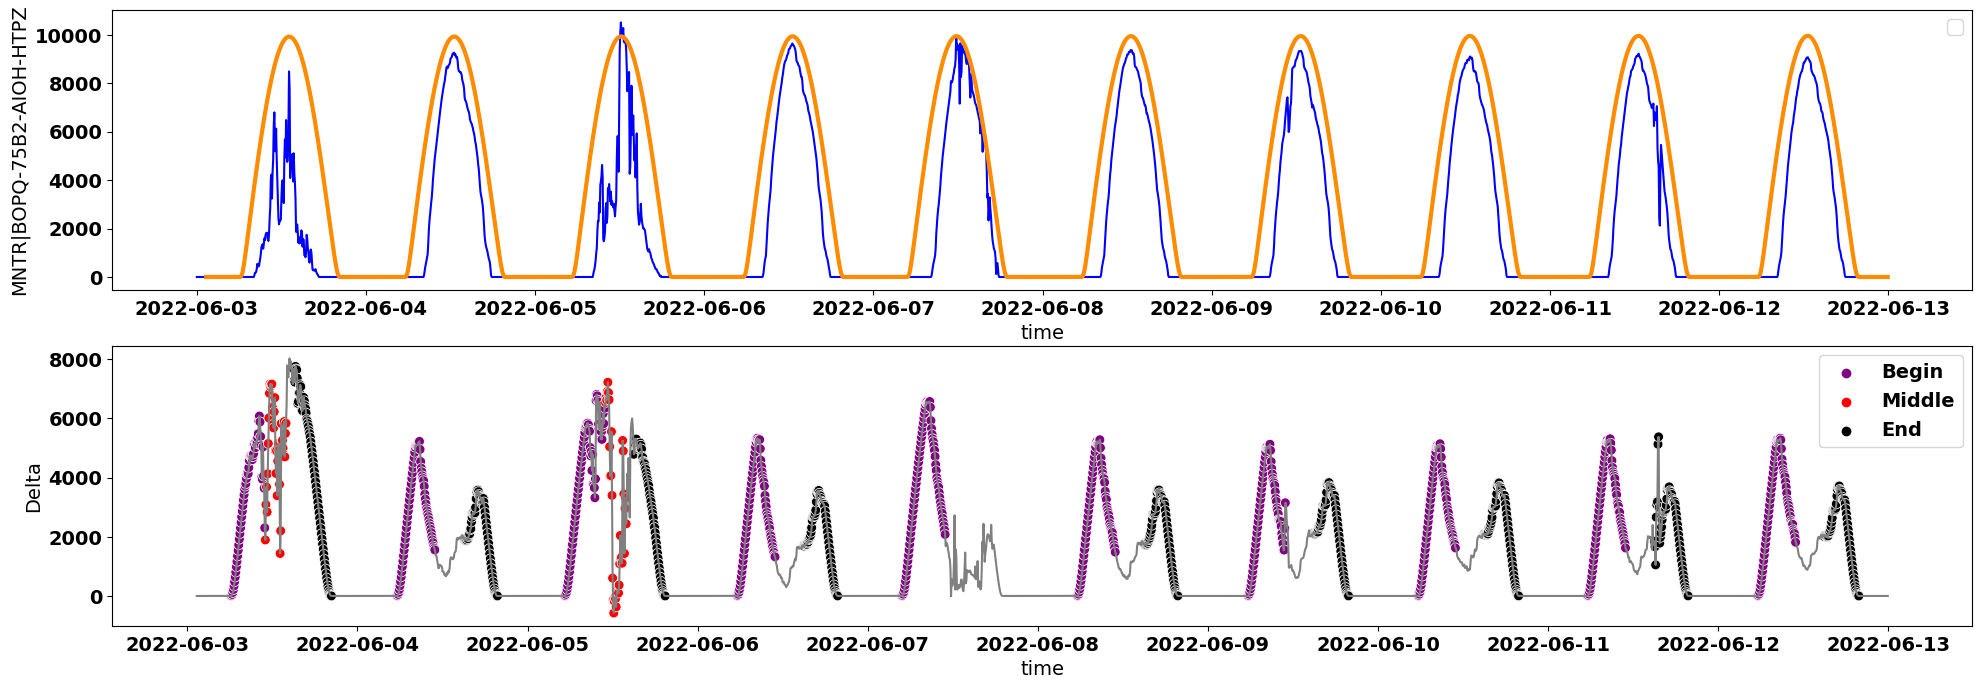

In [57]:

fig, axe = plt.subplots(nrows=2, figsize=(24, 8))
sns.scatterplot(data = df_MID, x='time', y='Delta', hue='Recurring_daily', palette ={'Begin': 'purple', 'Middle': 'red', 'End': 'black'}, ax=axe[1], zorder=2, s=50)
sns.lineplot(data=df_MID, x='time', y=MIDname, color='blue', ax=axe[0])
sns.lineplot(data=df_MID, x='time', y='shift_theor.W', color='darkorange', linewidth=3, ax=axe[0])
axe[0].legend()
sns.lineplot(data=df_MID, x='time', y='Delta', color='gray', ax=axe[1])

In [58]:
# can only consider clear-sky power generation